# Landing Zone Detection with RF-DETR
## CS4824 Final Project - Google Colab Training Notebook

This notebook trains an RF-DETR model to detect landing zones from Blender-rendered frames.

### Instructions:
1. Run this notebook with GPU enabled: Runtime → Change runtime type → GPU (T4)
2. The notebook will clone the GitHub repo, unzip the dataset, and train the model
3. After training, the model will be saved to Google Drive

## 1. Setup and Installation

First, check GPU availability and install dependencies.

In [1]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

PyTorch version: 2.9.1+rocm6.4
CUDA available: True
CUDA version: None
GPU: AMD Radeon Graphics
GPU Memory: 23.98 GB


/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory


## 2. Clone GitHub Repository

Clone the project repository containing the dataset and scripts.

In [2]:
# Clone the GitHub repository
!git clone https://github.com/PieLord757/CS4824FinalProject.git
%cd CS4824FinalProject

# List contents
!ls -la

Cloning into 'CS4824FinalProject'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 18 (delta 1), reused 4 (delta 1), pack-reused 11 (from 2)
Receiving objects: 100% (18/18), 70.48 MiB | 4.30 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Filtering content: 100% (1/1), 357.97 MiB | 3.73 MiB/s, done.
/home/mikhail/Documents/vt/2025Fall/CS4824/Project/CS4824FinalProject
total 366624
drwxr-xr-x 1 mikhail mikhail       360 Dec  1 14:07 ./
drwxr-xr-x 1 mikhail mikhail       106 Dec  1 14:05 ../
-rw-r--r-- 1 mikhail mikhail 375354578 Dec  1 14:07 coco-dataset.zip
-rw-r--r-- 1 mikhail mikhail       962 Dec  1 14:05 config_landing_zone.yaml
-rw-r--r-- 1 mikhail mikhail     10137 Dec  1 14:05 convert_to_coco.py
drwxr-xr-x 1 mikhail mikhail       128 Dec  1 14:07 .git/
-rw-r--r-- 1 mikhail mikhail        42 Dec  1 14:05 .gitattributes
-rw-r--r-- 1 mikhail mikhail       307 Dec  1 14:05 .gitignore
-

## 3. Unzip Dataset & Install RF-DETR

Extract the COCO dataset and install the RF-DETR library.

In [3]:
# Unzip the dataset
import zipfile
import os

zip_path = 'coco-dataset.zip'
extract_path = '.'

print("Extracting dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("✓ Dataset extracted!")

# Verify extraction
dataset_path = 'coco-dataset'
if os.path.exists(dataset_path):
    print(f"✓ Dataset directory exists: {dataset_path}")
    for split in ['train', 'valid', 'test']:
        split_path = os.path.join(dataset_path, split)
        if os.path.exists(split_path):
            num_files = len(os.listdir(split_path))
            print(f"  {split}: {num_files} files")
else:
    print("✗ Dataset extraction failed")

Extracting dataset...
✓ Dataset extracted!
✓ Dataset directory exists: coco-dataset
  train: 417 files
  valid: 120 files
  test: 61 files


## 4. Install RF-DETR

Clone and install the RF-DETR library from Roboflow.

In [4]:
# Install RF-DETR
!pip install rfdetr

print("\n✓ RF-DETR installed successfully!")


✓ RF-DETR installed successfully!


## 5. Verify Dataset Structure

Check that the COCO dataset is properly structured.

In [5]:
import os
import json

# Check dataset structure
dataset_path = "coco-dataset"

print("Dataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files) - 5} more files")

# Check annotation files
print("\n" + "="*50)
for split in ['train', 'valid', 'test']:
    anno_file = f"{dataset_path}/{split}/_annotations.coco.json"
    if os.path.exists(anno_file):
        with open(anno_file, 'r') as f:
            data = json.load(f)
        print(f"\n{split.upper()} split:")
        print(f"  Images: {len(data['images'])}")
        print(f"  Annotations: {len(data['annotations'])}")
        print(f"  Categories: {data['categories']}")

Dataset structure:
coco-dataset/
  dataset_info.json
  valid/
    0071.png
    0059.png
    0449.png
    0474.png
    0138.png
    ... and 115 more files
  test/
    0105.png
    0104.png
    0072.png
    0476.png
    _annotations.coco.json
    ... and 56 more files
  annotations/
    instances_test.json
    instances_train.json
    instances_val.json
  train/
    0298.png
    0267.png
    0501.png
    0515.png
    0273.png
    ... and 412 more files


TRAIN split:
  Images: 416
  Annotations: 402
  Categories: [{'id': 0, 'name': 'Landing Zone', 'supercategory': 'zone'}]

VALID split:
  Images: 119
  Annotations: 118
  Categories: [{'id': 0, 'name': 'Landing Zone', 'supercategory': 'zone'}]

TEST split:
  Images: 60
  Annotations: 56
  Categories: [{'id': 0, 'name': 'Landing Zone', 'supercategory': 'zone'}]


## 6. Visualize Sample Images

Display some training images with their bounding boxes.

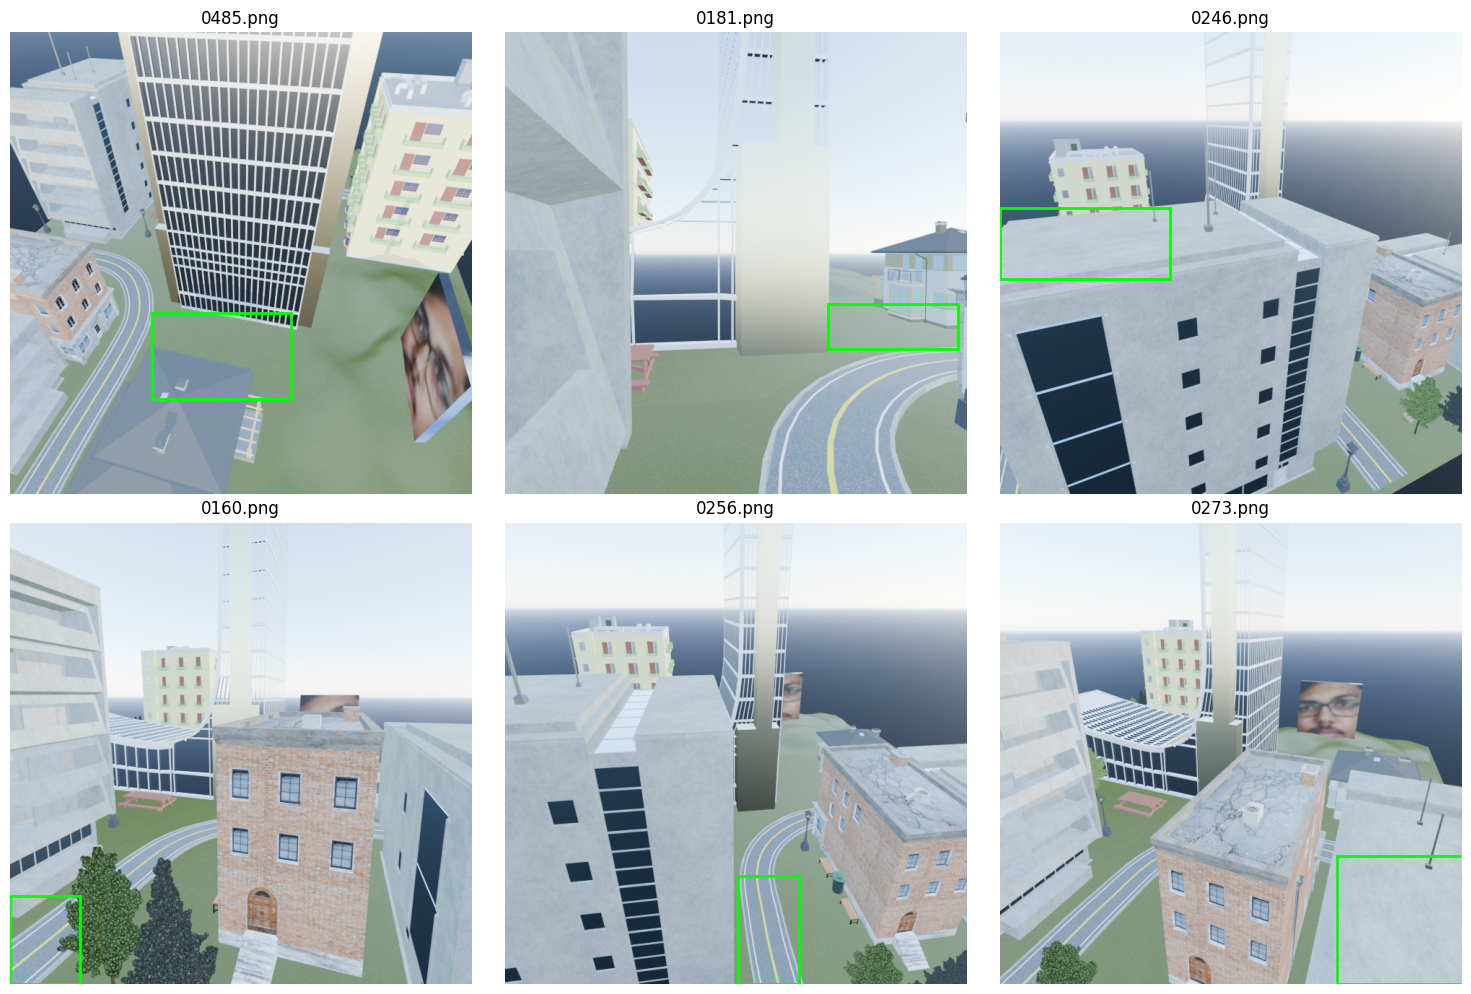

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# Load training annotations
with open('coco-dataset/train/_annotations.coco.json', 'r') as f:
    train_data = json.load(f)

# Create image_id to annotations mapping
img_to_annos = {}
for anno in train_data['annotations']:
    img_id = anno['image_id']
    if img_id not in img_to_annos:
        img_to_annos[img_id] = []
    img_to_annos[img_id].append(anno)

# Display first 6 images with annotations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, img_info in enumerate(train_data['images'][:6]):
    img_path = f"coco-dataset/train/{img_info['file_name']}"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax = axes[idx]
    ax.imshow(img)

    # Draw bounding boxes
    if img_info['id'] in img_to_annos:
        for anno in img_to_annos[img_info['id']]:
            x, y, w, h = anno['bbox']
            rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

    ax.set_title(f"{img_info['file_name']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## 7. Train the RF-DETR Model

Train the model using the RF-DETR library.

In [7]:
import torch
from rfdetr import RFDETRNano

def train_landing_zone_model():
    """Train RF-DETR model for landing zone detection"""

    dataset_path = "coco-dataset"

    # Initialize model
    print("Initializing RF-DETR Nano model...")
    model = RFDETRNano()

    print(f"\nTraining Configuration:")
    print(f"  Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
    print(f"  Dataset: {dataset_path}")

    # Train model
    print("\nStarting training...")
    model.train(
        dataset_dir=dataset_path,
        epochs=100,
        batch_size=16,
        grad_accum_steps=4,
        lr=1e-4
    )

    print("\n✓ Training completed!")

    return model

# Run training
model = train_landing_zone_model()

Initializing RF-DETR Nano model...


rf-detr-nano.pth: 100%|██████████| 349M/349M [01:22<00:00, 4.44MiB/s] 


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights

Training Configuration:
  Device: cuda
  Dataset: coco-dataset

Starting training...
Unable to initialize TensorBoard. Logging is turned off for this session.  Run 'pip install tensorboard' to enable logging.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=1, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=16, weight_decay=0.0001, epochs=100, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_

fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


Epoch: [0]  [0/6]  eta: 0:00:20  lr: 0.000100  class_error: -0.00  loss: 9.3031 (9.3031)  loss_ce: 0.5493 (0.5493)  loss_bbox: 1.0257 (1.0257)  loss_giou: 1.4131 (1.4131)  loss_ce_0: 0.5225 (0.5225)  loss_bbox_0: 1.0828 (1.0828)  loss_giou_0: 1.4863 (1.4863)  loss_ce_enc: 0.5052 (0.5052)  loss_bbox_enc: 1.1140 (1.1140)  loss_giou_enc: 1.6041 (1.6041)  loss_ce_unscaled: 0.5493 (0.5493)  class_error_unscaled: -0.0000 (-0.0000)  loss_bbox_unscaled: 0.2051 (0.2051)  loss_giou_unscaled: 0.7065 (0.7065)  cardinality_error_unscaled: 0.9375 (0.9375)  loss_ce_0_unscaled: 0.5225 (0.5225)  loss_bbox_0_unscaled: 0.2166 (0.2166)  loss_giou_0_unscaled: 0.7432 (0.7432)  cardinality_error_0_unscaled: 0.9375 (0.9375)  loss_ce_enc_unscaled: 0.5052 (0.5052)  loss_bbox_enc_unscaled: 0.2228 (0.2228)  loss_giou_enc_unscaled: 0.8020 (0.8020)  cardinality_error_enc_unscaled: 0.9375 (0.9375)  time: 3.4330  data: 1.3461  max mem: 9508
Epoch: [0]  [5/6]  eta: 0:00:01  lr: 0.000100  class_error: -0.00  loss: 7.49

## 8. Check Training Outputs

List the model checkpoints saved during training.

In [2]:
# Check for training outputs
import os
import glob

# Find .pth files (model checkpoints)
pth_files = glob.glob("**/*.pth", recursive=True)
print("Model checkpoints found:")
for f in pth_files:
    size = os.path.getsize(f) / (1024*1024)
    print(f"  {f} ({size:.2f} MB)")

Model checkpoints found:
  CS4824FinalProject/rf-detr-nano.pth (349.32 MB)
  CS4824FinalProject/output/checkpoint.pth (462.00 MB)
  CS4824FinalProject/output/checkpoint_best_regular.pth (346.85 MB)
  CS4824FinalProject/output/checkpoint_best_ema.pth (345.61 MB)
  CS4824FinalProject/output/checkpoint0009.pth (462.01 MB)
  CS4824FinalProject/output/checkpoint0019.pth (462.01 MB)
  CS4824FinalProject/output/checkpoint0029.pth (462.01 MB)
  CS4824FinalProject/output/checkpoint0039.pth (462.01 MB)
  CS4824FinalProject/output/checkpoint0049.pth (462.01 MB)
  CS4824FinalProject/output/checkpoint0059.pth (462.01 MB)
  CS4824FinalProject/output/checkpoint0069.pth (462.01 MB)
  CS4824FinalProject/output/checkpoint0079.pth (462.01 MB)
  CS4824FinalProject/output/checkpoint0089.pth (462.01 MB)
  CS4824FinalProject/output/checkpoint0099.pth (462.01 MB)
  CS4824FinalProject/output/checkpoint_best_total.pth (115.17 MB)
  CS4824FinalProject/output/eval/latest.pth (0.23 MB)
  CS4824FinalProject/output/

## 9. Test Inference

Run inference on test images to see model predictions.

/home/mikhail/Documents/vt/2025Fall/CS4824/Project/CS4824FinalProject
Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


Model is not optimized for inference. Latency may be higher than expected. You can optimize the model for inference by calling model.optimize_for_inference().


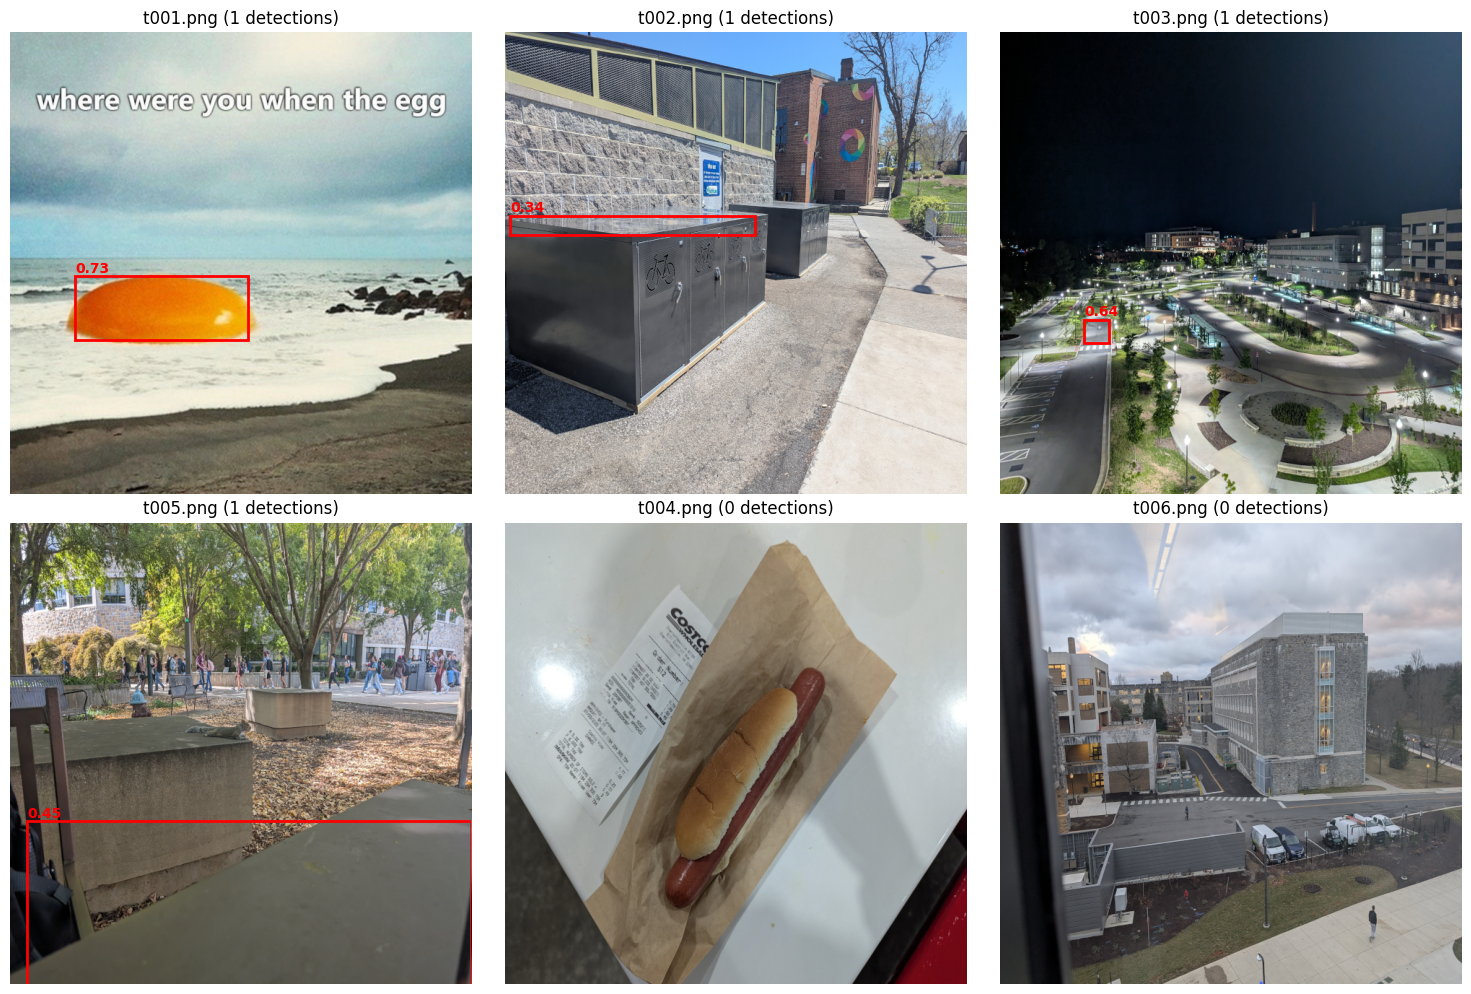


✓ Inference completed on 6 test images


In [ ]:
# Test inference on sample images
from PIL import Image
import matplotlib.pyplot as plt
import os

from rfdetr import RFDETRNano

model = RFDETRNano(pretrain_weights="output/checkpoint0099.pth")

# Get test images
test_dir = "/home/mikhail/Documents/vt/2025Fall/CS4824/Project/TestImages"
test_images = [f for f in os.listdir(test_dir) if f.endswith('.png')][0:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, img_name in enumerate(test_images):
    img_path = os.path.join(test_dir, img_name)

    # Load image and convert RGBA to RGB if needed
    img = Image.open(img_path)
    if img.mode == 'RGBA':
        background = Image.new('RGB', img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])
        img_rgb = background
    else:
        img_rgb = img.convert('RGB')

    # Save temporary RGB image for prediction
    temp_path = f"/tmp/temp_{img_name}"
    img_rgb.save(temp_path)

    # Run inference - returns supervision.Detections object
    detections = model.predict(temp_path, threshold=0.3)

    # Display image
    ax = axes[idx]
    ax.imshow(img_rgb)

    # Draw detections - access arrays directly from Detections object
    det_count = 0
    if detections is not None and len(detections.xyxy) > 0:
        for i in range(len(detections.xyxy)):
            x1, y1, x2, y2 = detections.xyxy[i]
            conf = detections.confidence[i] if detections.confidence is not None else 1.0

            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                 linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1-5, f"{conf:.2f}", color='red', fontsize=10, weight='bold')
            det_count += 1

    ax.set_title(f"{img_name} ({det_count} detections)")
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Inference completed on {len(test_images)} test images")

## 10. Save Model to Google Drive

Mount Google Drive and save the trained model for later use.

In [14]:
# Mount Google Drive to save the model
from google.colab import drive
drive.mount('/content/drive')

# Save model to Drive
import shutil
import glob

drive_output = "/content/drive/MyDrive/landing_zone_model"
os.makedirs(drive_output, exist_ok=True)

# Find and copy model files
pth_files = glob.glob("**/*.pth", recursive=True)
for pth_file in pth_files:
    dst = os.path.join(drive_output, os.path.basename(pth_file))
    shutil.copy2(pth_file, dst)
    print(f"✓ Saved: {os.path.basename(pth_file)}")

print(f"\n✓ Model saved to Google Drive: {drive_output}")

Mounted at /content/drive
✓ Saved: rf-detr-nano.pth
✓ Saved: checkpoint0059.pth
✓ Saved: checkpoint_best_total.pth
✓ Saved: checkpoint.pth
✓ Saved: checkpoint_best_regular.pth
✓ Saved: checkpoint0019.pth
✓ Saved: checkpoint0049.pth
✓ Saved: checkpoint0039.pth
✓ Saved: checkpoint0079.pth
✓ Saved: checkpoint0069.pth
✓ Saved: checkpoint0009.pth
✓ Saved: checkpoint0029.pth
✓ Saved: checkpoint_best_ema.pth
✓ Saved: checkpoint0099.pth
✓ Saved: checkpoint0089.pth
✓ Saved: latest.pth
✓ Saved: 000.pth
✓ Saved: 050.pth

✓ Model saved to Google Drive: /content/drive/MyDrive/landing_zone_model


## Compute some more evalulation Metrics

Running model evaluation on test set...

Evaluating 60 test images...
IoU threshold: 0.5
Confidence threshold: 0.3
--------------------------------------------------

EVALUATION RESULTS

Detection Counts:
  True Positives:  51
  False Positives: 6
  False Negatives: 4
  True Negatives:  4

Metrics:
  Precision:       0.8947
  Recall:          0.9273
  F1-Score:        0.9107
  Image Accuracy:  0.9833


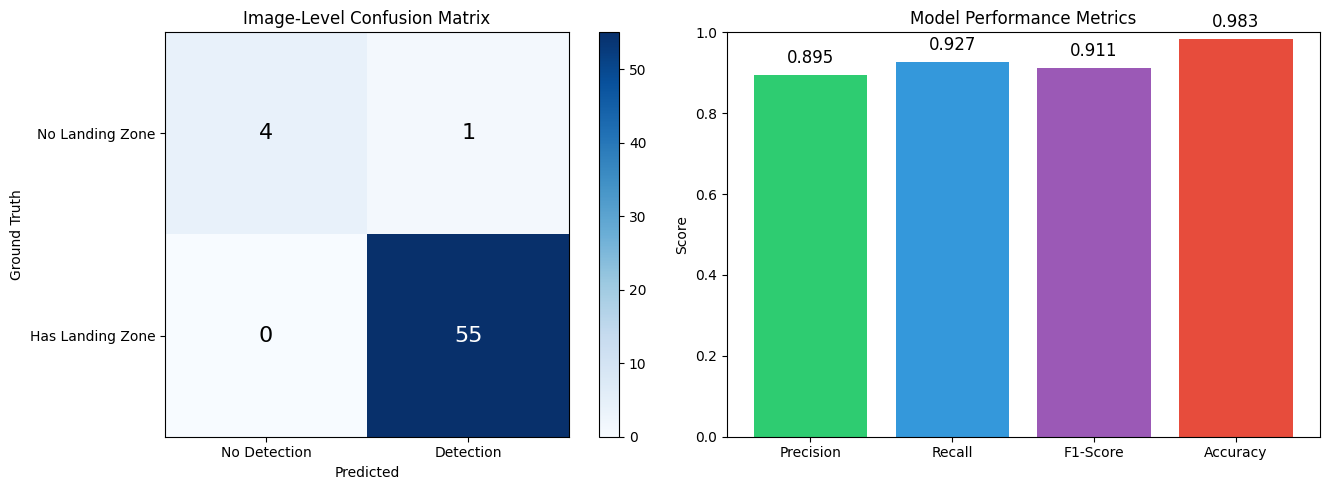

In [ ]:
# Evaluation Metrics - Confusion Matrix, Precision, Recall, F1-Score
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import os

def calculate_box_overlap(pred_box, gt_box):
    """Calculate Intersection over Union between two bounding boxes"""
    # Get coordinates
    px1, py1, px2, py2 = pred_box
    gx1, gy1, gx2, gy2 = gt_box

    # Calculate intersection coordinates
    inter_x1 = max(px1, gx1)
    inter_y1 = max(py1, gy1)
    inter_x2 = min(px2, gx2)
    inter_y2 = min(py2, gy2)

    # Calculate areas
    inter_width = max(0, inter_x2 - inter_x1)
    inter_height = max(0, inter_y2 - inter_y1)
    intersection_area = inter_width * inter_height

    pred_area = (px2 - px1) * (py2 - py1)
    gt_area = (gx2 - gx1) * (gy2 - gy1)
    union_area = pred_area + gt_area - intersection_area

    if union_area == 0:
        return 0.0
    return intersection_area / union_area

def run_evaluation(model, test_dir, annotations_file, overlap_threshold=0.5, conf_threshold=0.3):
    """Run evaluation on test set and compute metrics"""

    # Load ground truth annotations
    with open(annotations_file, 'r') as f:
        gt_data = json.load(f)

    # Build lookup dictionaries
    filename_to_id = {img['file_name']: img['id'] for img in gt_data['images']}
    id_to_annotations = {}
    for ann in gt_data['annotations']:
        img_id = ann['image_id']
        if img_id not in id_to_annotations:
            id_to_annotations[img_id] = []
        # Convert COCO format [x, y, w, h] to [x1, y1, x2, y2]
        x, y, w, h = ann['bbox']
        id_to_annotations[img_id].append([x, y, x + w, y + h])

    # Tracking variables
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    all_gt_labels = []  # 1 if image has landing zone, 0 otherwise
    all_pred_labels = []  # 1 if model predicted landing zone, 0 otherwise

    test_images = [f for f in os.listdir(test_dir) if f.endswith('.png')]

    print(f"Evaluating {len(test_images)} test images...")
    print(f"IoU threshold: {overlap_threshold}")
    print(f"Confidence threshold: {conf_threshold}")
    print("-" * 50)

    for img_name in test_images:
        img_path = os.path.join(test_dir, img_name)

        # Handle RGBA images
        img = Image.open(img_path)
        if img.mode == 'RGBA':
            bg = Image.new('RGB', img.size, (255, 255, 255))
            bg.paste(img, mask=img.split()[3])
            temp_path = f"/tmp/eval_{img_name}"
            bg.save(temp_path)
            img_path = temp_path

        # Get predictions
        predictions = model.predict(img_path, threshold=conf_threshold)
        pred_boxes = predictions.xyxy if len(predictions.xyxy) > 0 else []

        # Get ground truth boxes
        img_id = filename_to_id.get(img_name, None)
        gt_boxes = id_to_annotations.get(img_id, []) if img_id else []

        has_gt = len(gt_boxes) > 0
        has_pred = len(pred_boxes) > 0

        all_gt_labels.append(1 if has_gt else 0)
        all_pred_labels.append(1 if has_pred else 0)

        if has_gt and has_pred:
            # Check if predictions match ground truth
            gt_matched = [False] * len(gt_boxes)
            for pred_box in pred_boxes:
                best_overlap = 0
                best_gt_idx = -1
                for gt_idx, gt_box in enumerate(gt_boxes):
                    if not gt_matched[gt_idx]:
                        overlap = calculate_box_overlap(pred_box, gt_box)
                        if overlap > best_overlap:
                            best_overlap = overlap
                            best_gt_idx = gt_idx

                if best_overlap >= overlap_threshold and best_gt_idx >= 0:
                    true_positives += 1
                    gt_matched[best_gt_idx] = True
                else:
                    false_positives += 1

            # Count unmatched ground truth as false negatives
            false_negatives += sum(1 for matched in gt_matched if not matched)

        elif has_gt and not has_pred:
            # Missed all ground truth boxes
            false_negatives += len(gt_boxes)

        elif not has_gt and has_pred:
            # Predicted on image with no ground truth
            false_positives += len(pred_boxes)

        else:
            # No ground truth and no predictions (true negative at image level)
            true_negatives += 1

    # Calculate metrics
    total_predictions = true_positives + false_positives
    total_ground_truth = true_positives + false_negatives

    precision = true_positives / total_predictions if total_predictions > 0 else 0
    recall = true_positives / total_ground_truth if total_ground_truth > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Image-level accuracy
    correct_images = sum(1 for gt, pred in zip(all_gt_labels, all_pred_labels) if gt == pred)
    image_accuracy = correct_images / len(test_images) if len(test_images) > 0 else 0

    return {
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'true_negatives': true_negatives,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'image_accuracy': image_accuracy,
        'gt_labels': all_gt_labels,
        'pred_labels': all_pred_labels
    }

def display_results(metrics):
    """Display evaluation results with confusion matrix"""

    print("\n" + "=" * 50)
    print("EVALUATION RESULTS")
    print("=" * 50)

    print(f"\nDetection Counts:")
    print(f"  True Positives:  {metrics['true_positives']}")
    print(f"  False Positives: {metrics['false_positives']}")
    print(f"  False Negatives: {metrics['false_negatives']}")
    print(f"  True Negatives:  {metrics['true_negatives']}")

    print(f"\nMetrics:")
    print(f"  Precision:       {metrics['precision']:.4f}")
    print(f"  Recall:          {metrics['recall']:.4f}")
    print(f"  F1-Score:        {metrics['f1_score']:.4f}")
    print(f"  Image Accuracy:  {metrics['image_accuracy']:.4f}")

    # Create confusion matrix plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Image-level confusion matrix
    cm = np.array([[0, 0], [0, 0]])
    for gt, pred in zip(metrics['gt_labels'], metrics['pred_labels']):
        cm[gt][pred] += 1

    ax1 = axes[0]
    im1 = ax1.imshow(cm, cmap='Blues')
    ax1.set_xticks([0, 1])
    ax1.set_yticks([0, 1])
    ax1.set_xticklabels(['No Detection', 'Detection'])
    ax1.set_yticklabels(['No Landing Zone', 'Has Landing Zone'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Ground Truth')
    ax1.set_title('Image-Level Confusion Matrix')

    # Add text annotations
    for i in range(2):
        for j in range(2):
            color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax1.text(j, i, str(cm[i, j]), ha='center', va='center', colkor=color, fontsize=16)

    plt.colorbar(im1, ax=ax1)

    # Bar chart of metrics
    ax2 = axes[1]
    metric_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
    metric_values = [metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['image_accuracy']]
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']

    bars = ax2.bar(metric_names, metric_values, color=colors)
    ax2.set_ylim(0, 1.0)
    ax2.set_ylabel('Score')
    ax2.set_title('Model Performance Metrics')

    # Add value labels on bars
    for bar, val in zip(bars, metric_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

# Run evaluation
test_dir = "coco-dataset/test"
annotations_file = "coco-dataset/test/_annotations.coco.json"

print("Running model evaluation on test set...\n")
metrics = run_evaluation(model, test_dir, annotations_file, overlap_threshold=0.5, conf_threshold=0.3)
display_results(metrics)